In [ ]:
!pip install findspark

In [ ]:
import findspark
findspark.init()

In [ ]:
from pyspark.sql import SparkSession
from pyspark import SparkContext
from pyspark.sql.functions import col, when, avg, count, lit, window
from pyspark.sql.window import Window

# Initialize Spark Session with Spark UI enabled
sc = SparkContext("local", "Distributed Data Cleaning/Processing")
spark = SparkSession(sc)
print(sc.uiWebUrl)
# Load dataset
# Replace 'your_file.csv' with your dataset file
df = spark.read.csv('project.csv', header=True, inferSchema=True)
df = df.limit(100000)

df.printSchema()

# Stop the SparkContext to free resources (optional)
# sc.stop()


Py4JJavaError: An error occurred while calling None.org.apache.spark.api.java.JavaSparkContext.
: org.apache.spark.SparkException: Only one SparkContext should be running in this JVM (see SPARK-2243).The currently running SparkContext was created at:
org.apache.spark.api.java.JavaSparkContext.<init>(JavaSparkContext.scala:58)
java.base/jdk.internal.reflect.NativeConstructorAccessorImpl.newInstance0(Native Method)
java.base/jdk.internal.reflect.NativeConstructorAccessorImpl.newInstance(NativeConstructorAccessorImpl.java:62)
java.base/jdk.internal.reflect.DelegatingConstructorAccessorImpl.newInstance(DelegatingConstructorAccessorImpl.java:45)
java.base/java.lang.reflect.Constructor.newInstance(Constructor.java:490)
py4j.reflection.MethodInvoker.invoke(MethodInvoker.java:247)
py4j.reflection.ReflectionEngine.invoke(ReflectionEngine.java:374)
py4j.Gateway.invoke(Gateway.java:238)
py4j.commands.ConstructorCommand.invokeConstructor(ConstructorCommand.java:80)
py4j.commands.ConstructorCommand.execute(ConstructorCommand.java:69)
py4j.ClientServerConnection.waitForCommands(ClientServerConnection.java:182)
py4j.ClientServerConnection.run(ClientServerConnection.java:106)
java.base/java.lang.Thread.run(Thread.java:829)
	at org.apache.spark.SparkContext$.$anonfun$assertNoOtherContextIsRunning$2(SparkContext.scala:2840)
	at scala.Option.foreach(Option.scala:407)
	at org.apache.spark.SparkContext$.assertNoOtherContextIsRunning(SparkContext.scala:2837)
	at org.apache.spark.SparkContext$.markPartiallyConstructed(SparkContext.scala:2927)
	at org.apache.spark.SparkContext.<init>(SparkContext.scala:99)
	at org.apache.spark.api.java.JavaSparkContext.<init>(JavaSparkContext.scala:58)
	at java.base/jdk.internal.reflect.NativeConstructorAccessorImpl.newInstance0(Native Method)
	at java.base/jdk.internal.reflect.NativeConstructorAccessorImpl.newInstance(NativeConstructorAccessorImpl.java:62)
	at java.base/jdk.internal.reflect.DelegatingConstructorAccessorImpl.newInstance(DelegatingConstructorAccessorImpl.java:45)
	at java.base/java.lang.reflect.Constructor.newInstance(Constructor.java:490)
	at py4j.reflection.MethodInvoker.invoke(MethodInvoker.java:247)
	at py4j.reflection.ReflectionEngine.invoke(ReflectionEngine.java:374)
	at py4j.Gateway.invoke(Gateway.java:238)
	at py4j.commands.ConstructorCommand.invokeConstructor(ConstructorCommand.java:80)
	at py4j.commands.ConstructorCommand.execute(ConstructorCommand.java:69)
	at py4j.ClientServerConnection.waitForCommands(ClientServerConnection.java:182)
	at py4j.ClientServerConnection.run(ClientServerConnection.java:106)
	at java.base/java.lang.Thread.run(Thread.java:829)


In [ ]:
!pip install pyngrok
from pyngrok import ngrok



In [ ]:
!ngrok config add-authtoken 2ooVcI9nctf29nB5YGdyLUsFef1_E6GMajTU6nZz9KPbQyz4


Authtoken saved to configuration file: /root/.config/ngrok/ngrok.yml


In [ ]:
# Operation 1: Correcting feature names
# Rename columns with dots
df = df.withColumnRenamed("pm2.5", "pm25") \
       .withColumnRenamed("pm2.5_avg", "pm25_avg") \
       .withColumnRenamed("pm10_avg", "pm10avg") \
       .withColumnRenamed("o3_8hr", "o3_8hr_avg") \
       .withColumnRenamed("co_8hr", "co_8hr_avg")


In [ ]:
# Operation 2: Correcting data_types
from pyspark.sql.functions import to_timestamp
# Convert renamed numeric columns to double
numeric_cols = ['aqi', 'so2', 'co', 'o3', 'o3_8hr_avg', 'pm10', 'pm25', 'no2',
                'nox', 'no', 'windspeed', 'winddirec', 'co_8hr_avg', 'pm25_avg',
                'pm10avg', 'so2_avg']

for col_name in numeric_cols:
    df = df.withColumn(col_name, col(col_name).cast('double'))
# Convert the 'date' column to a proper date format
df = df.withColumn('date', to_timestamp('date', 'yyyy-MM-dd HH:mm'))
df.printSchema()

root
 |-- date: timestamp (nullable = true)
 |-- sitename: string (nullable = true)
 |-- county: string (nullable = true)
 |-- aqi: double (nullable = true)
 |-- pollutant: string (nullable = true)
 |-- status: string (nullable = true)
 |-- so2: double (nullable = true)
 |-- co: double (nullable = true)
 |-- o3: double (nullable = true)
 |-- o3_8hr_avg: double (nullable = true)
 |-- pm10: double (nullable = true)
 |-- pm25: double (nullable = true)
 |-- no2: double (nullable = true)
 |-- nox: double (nullable = true)
 |-- no: double (nullable = true)
 |-- windspeed: double (nullable = true)
 |-- winddirec: double (nullable = true)
 |-- unit: string (nullable = true)
 |-- co_8hr_avg: double (nullable = true)
 |-- pm25_avg: double (nullable = true)
 |-- pm10avg: double (nullable = true)
 |-- so2_avg: double (nullable = true)
 |-- longitude: double (nullable = true)
 |-- latitude: double (nullable = true)
 |-- siteid: double (nullable = true)



In [ ]:
df.count()

100000

In [ ]:
# Operation 3: Replacing Null values with Median Mode
from pyspark.sql.functions import col, when, avg
from pyspark.sql import functions as F

# List of numerical columns
numeric_cols = ['aqi', 'so2', 'co', 'o3', 'o3_8hr_avg', 'pm10', 'pm25', 'no2',
                'nox', 'no', 'windspeed', 'winddirec', 'co_8hr_avg', 'pm25_avg',
                'pm10avg', 'so2_avg']

# Clean numerical columns: Replace `'-'` with `null`
for col_name in numeric_cols:
    df = df.withColumn(col_name,when(col(col_name).contains('-'), None).otherwise(col(col_name)))

# Replace `null` in numerical columns with median
for col_name in numeric_cols:
    # Calculate the median
    median = df.approxQuantile(col_name, [0.5], 0)[0]

    # Replace `null` with median
    df = df.fillna({col_name: median})


# List of categorical columns
categorical_cols = ['sitename', 'county', 'pollutant', 'status']

# Clean categorical columns: Replace rows with `'-'` or `null` values
for col_name in categorical_cols:
    df = df.withColumn(col_name, when(col(col_name).contains('-'), None).otherwise(col(col_name)))

# Replace `null` values in categorical columns with mode
for col_name in categorical_cols:
    # Calculate the mode (most frequent value)
    mode_value = df.groupBy(col_name).agg(F.count(col_name).alias('count')).orderBy(F.desc('count')).first()[0]

    # Replace `null` with mode
    df = df.fillna({col_name: mode_value})

In [ ]:
df.count()

100000

In [ ]:
columns_with_nulls = {}
# Check if `null` exists in each column
for col_name in df.columns:
    null_count = df.filter(col(col_name).isNull()).count()
    if null_count > 0:
        columns_with_nulls[col_name] = null_count

# Display the columns containing `null` values
if columns_with_nulls:
    print("Columns containing `null` values:")
    for col_name, count in columns_with_nulls.items():
        print(f"  - {col_name}: {count} occurrences")
else:
    print("No columns contain `null` values.")


Columns containing `null` values:
  - unit: 100000 occurrences


In [ ]:
# Operation 4: Removing irrelavent features
df = df.drop('unit', 'siteid', 'pollutant')

In [ ]:
df.columns

['date',
 'sitename',
 'county',
 'aqi',
 'status',
 'so2',
 'co',
 'o3',
 'o3_8hr_avg',
 'pm10',
 'pm25',
 'no2',
 'nox',
 'no',
 'windspeed',
 'winddirec',
 'co_8hr_avg',
 'pm25_avg',
 'pm10avg',
 'so2_avg',
 'longitude',
 'latitude']

In [ ]:
# Operation 5: Filter Invalid Geospatial Data
df = df.filter((col('longitude') >= -180) & (col('longitude') <= 180) &
               (col('latitude') >= -90) & (col('latitude') <= 90))

In [ ]:
df.printSchema()

root
 |-- date: timestamp (nullable = true)
 |-- sitename: string (nullable = false)
 |-- county: string (nullable = false)
 |-- aqi: double (nullable = false)
 |-- status: string (nullable = false)
 |-- so2: double (nullable = false)
 |-- co: double (nullable = false)
 |-- o3: double (nullable = false)
 |-- o3_8hr_avg: double (nullable = false)
 |-- pm10: double (nullable = false)
 |-- pm25: double (nullable = false)
 |-- no2: double (nullable = false)
 |-- nox: double (nullable = false)
 |-- no: double (nullable = false)
 |-- windspeed: double (nullable = false)
 |-- winddirec: double (nullable = false)
 |-- co_8hr_avg: double (nullable = false)
 |-- pm25_avg: double (nullable = false)
 |-- pm10avg: double (nullable = false)
 |-- so2_avg: double (nullable = false)
 |-- longitude: double (nullable = true)
 |-- latitude: double (nullable = true)



In [ ]:
# Operation 6: Removing outliers

def remove_outliers(df, col_name):
    q1, q3 = df.approxQuantile(col_name, [0.25, 0.75], 0)
    iqr = q3 - q1
    lower_bound = q1 - 1.5 * iqr
    upper_bound = q3 + 1.5 * iqr
    return df.filter((col(col_name) >= lower_bound) & (col(col_name) <= upper_bound))
numerical_cols = [
    'aqi', 'so2', 'co', 'o3', 'o3_8hr_avg', 'pm10', 'pm25', 'no2',
    'nox', 'no', 'windspeed', 'winddirec', 'co_8hr_avg', 'pm25_avg',
    'pm10avg', 'so2_avg', 'longitude', 'latitude'
]

for col_name in numeric_cols:
    dff = remove_outliers(df, col_name)


In [ ]:
type(dff)

pyspark.sql.dataframe.DataFrame

RMSE for LinearRegression: 5.997184896032873
RMSE for DecisionTreeRegressor: 3.89783073788256
RMSE for RandomForestRegressor: 4.849760816167788
RMSE for GBTRegressor: 2.837115840577493
Accuracy for LogisticRegression (interpreted as RMSE): 5.939527120106812
Silhouette score for KMeans: 0.13445065497385514


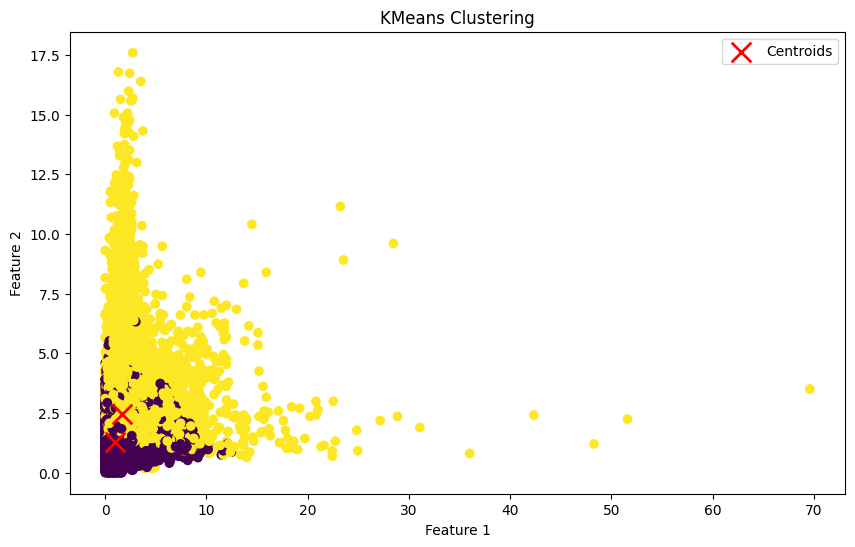

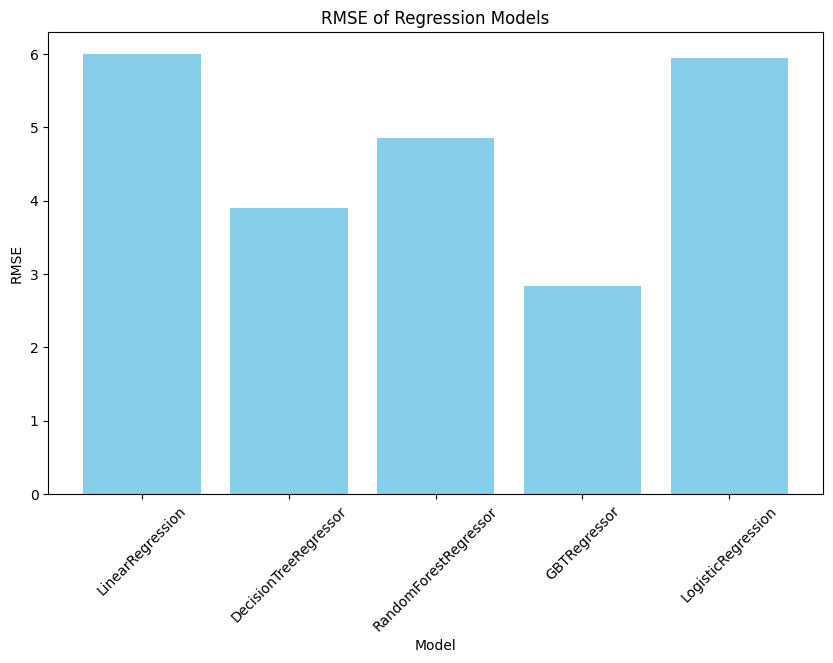

In [ ]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, to_timestamp
from pyspark.ml import Pipeline
from pyspark.ml.feature import StringIndexer, VectorAssembler, StandardScaler
from pyspark.ml.regression import LinearRegression, DecisionTreeRegressor, RandomForestRegressor, GBTRegressor
from pyspark.ml.evaluation import RegressionEvaluator, ClusteringEvaluator
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.clustering import KMeans
import matplotlib.pyplot as plt

# Initialize Spark session
spark = SparkSession.builder.appName("MLPipeline").getOrCreate()

# Ensure the SparkContext is accessible
sc = spark.sparkContext

# Load data into DataFrame
dff = spark.read.csv("project.csv", header=True, inferSchema=True)

# Rename columns to remove dots
dff = dff.withColumnRenamed("pm2.5", "pm25") \
         .withColumnRenamed("pm2.5_avg", "pm25_avg")

# Convert columns to correct data types
numeric_cols = ['so2', 'co', 'o3', 'o3_8hr', 'pm10', 'pm25', 'no2', 'nox', 'no', 'windspeed', 'winddirec', 'co_8hr', 'pm25_avg', 'pm10_avg', 'so2_avg']
for col_name in numeric_cols:
    dff = dff.withColumn(col_name, col(col_name).cast("double"))

# Drop rows with null values in the numeric columns
dff = dff.na.drop(subset=numeric_cols)

# List of categorical columns
categorical_cols = ['status', 'sitename', 'county']

# Step 1: Encode categorical columns using StringIndexer
indexers = []
for col_name in categorical_cols:
    indexer = StringIndexer(inputCol=col_name, outputCol=col_name + "_indexed")
    indexers.append(indexer)

# Step 2: Assemble features using VectorAssembler
assembler = VectorAssembler(inputCols=numeric_cols + [col + "_indexed" for col in categorical_cols], outputCol="features", handleInvalid="skip")

# Step 3: Scale numerical features
scaler = StandardScaler(inputCol="features", outputCol="scaledFeatures")

# Step 4: Create a list of regressors (you can add more algorithms if desired)
regressors = [
    LinearRegression(featuresCol="scaledFeatures", labelCol="aqi"),
    DecisionTreeRegressor(featuresCol="scaledFeatures", labelCol="aqi"),
    RandomForestRegressor(featuresCol="scaledFeatures", labelCol="aqi"),
    GBTRegressor(featuresCol="scaledFeatures", labelCol="aqi"),
    LogisticRegression(featuresCol="scaledFeatures", labelCol="aqi"),  # For binary regression
    KMeans(featuresCol="scaledFeatures", k=2)  # KMeans can also be used for regression-like tasks
]

# Step 5: Create a list of pipelines
pipelines = []
for regressor in regressors:
    pipeline = Pipeline(stages=indexers + [assembler, scaler, regressor])
    pipelines.append(pipeline)

# Step 6: Split the data into training and test sets
(trainingData, testData) = dff.randomSplit([0.7, 0.3], seed=42)

# Lists to store results for visualization
rmse_values = []
model_names = []
silhouette_scores = []

# Step 7: Fit and evaluate each pipeline
for pipeline in pipelines:
    model = pipeline.fit(trainingData)
    predictions = model.transform(testData)

    # Check if the current model is KMeans or LogisticRegression
    last_stage = pipeline.getStages()[-1]

    if isinstance(last_stage, KMeans):
        # Evaluate KMeans using ClusteringEvaluator (for clustering tasks)
        evaluator = ClusteringEvaluator(predictionCol="prediction")
        silhouette_score = evaluator.evaluate(predictions)
        silhouette_scores.append(silhouette_score)
        model_names.append("KMeans")
        print(f"Silhouette score for KMeans: {silhouette_score}")

        # Visualize KMeans clustering
        centers = model.stages[-1].clusterCenters()
        clustered_data = predictions.select("scaledFeatures", "prediction").toPandas()

        plt.figure(figsize=(10, 6))
        plt.scatter(clustered_data['scaledFeatures'].apply(lambda x: x[0]), clustered_data['scaledFeatures'].apply(lambda x: x[1]), c=clustered_data['prediction'], cmap='viridis')
        plt.scatter([center[0] for center in centers], [center[1] for center in centers], color='red', marker='x', s=200, linewidths=2, label='Centroids')
        plt.xlabel('Feature 1')
        plt.ylabel('Feature 2')
        plt.title('KMeans Clustering')
        plt.legend()
        plt.show()

    elif isinstance(last_stage, LogisticRegression):
        # For LogisticRegression, evaluate classification performance (e.g., using accuracy or other metrics)
        evaluator = RegressionEvaluator(labelCol="aqi", predictionCol="prediction", metricName="rmse")
        accuracy = evaluator.evaluate(predictions)  # You can change this to accuracy/evaluator specific to classification
        rmse_values.append(accuracy)
        model_names.append("LogisticRegression")
        print(f"Accuracy for LogisticRegression (interpreted as RMSE): {accuracy}")

    else:
        # For regression models (LinearRegression, DecisionTreeRegressor, etc.), use RegressionEvaluator
        evaluator = RegressionEvaluator(labelCol="aqi", predictionCol="prediction", metricName="rmse")
        rmse = evaluator.evaluate(predictions)
        rmse_values.append(rmse)
        model_names.append(type(last_stage).__name__)
        print(f"RMSE for {type(last_stage).__name__}: {rmse}")

# Plot RMSE values for regression models
plt.figure(figsize=(10, 6))
plt.bar(model_names[:len(rmse_values)], rmse_values, color='skyblue')
plt.xlabel('Model')
plt.ylabel('RMSE')
plt.title('RMSE of Regression Models')
plt.xticks(rotation=45)
plt.show()



# Stop the Spark session
spark.stop()


In [ ]:
from pyspark import SparkConf, SparkContext
conf = SparkConf().set("spark.ui.port", "4041")  # Set to a different port
sc = SparkContext(conf=conf)


In [ ]:
public_url = ngrok.connect(4041)
print("Access Spark UI at:", public_url)


Access Spark UI at: NgrokTunnel: "https://a2e5-34-106-110-205.ngrok-free.app" -> "http://localhost:4041"


In [ ]:
spark.stop()